# [**Visualizing COVID19 outbreak in India**](https://github.com/MoadComputer/covid19-visualization/blob/master/examples/COVID19_India.ipynb)
## Author: [Dr. Rahul Remanan](https://www.linkedin.com/in/rahulremanan/), CEO [Moad Computer](https://moad.computer)
### Contact: rahul@moad.computer

This notebook visualizes the COVID19 outbreak in India using GeoPandas and Bokeh.
## **[Run this notebook in Google Colab](https://colab.research.google.com/github/MoadComputer/covid19-visualization/blob/master/examples/COVID19_India.ipynb)**

## Install dependencies

In [0]:
%%capture
! python3 -m pip install fiona geopandas visvalingamwyatt

## Import libraries

In [0]:
import os
import math
import json
import bokeh
import geopandas
import numpy as np
import pandas as pd

from bokeh.io.doc import curdoc
from bokeh.plotting import figure
from bokeh.palettes import brewer, OrRd
from bokeh.plotting import show as plt_show
from bokeh.tile_providers import Vendors, get_provider
from bokeh.io import output_notebook, show, output_file
from bokeh.layouts import widgetbox, row, column, gridplot
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter
from bokeh.models import Slider, HoverTool, Select, Div, Range1d, WMTSTileSource, BoxZoomTool

## Load GeoJSON file of India

In [0]:
India_statewise = geopandas.read_file('https://github.com/MoadComputer/covid19-visualization/raw/master/data/GeoJSON_assets/India_statewise.geojson')

## Simplify GeoJSON geometry
GeoJSON geometry simplication is performed using Visvalingam-Wyatt polyline simplification algorithm. Enable geometry simplification by setting the flag: ``` enable_minifiedGeoJSON=True ```

The motivation for simplifying GeoJSON geometry is to improve the map rendering times. The compromise here is in the level of geometrical details. 

If the map rendering times are not important (offline applications), use the original GeoJSON file. The GeoJSON simplification steps can be turned-off, by setting the flag: ``` enable_minifiedGeoJSON=False ```

.

In [0]:
enable_minifiedGeoJSON=True

In [0]:
%%capture
if not os.path.exists('./India_statewise.geojson') and enable_minifiedGeoJSON:
  ! wget https://github.com/MoadComputer/covid19-visualization/raw/master/data/GeoJSON_assets/India_statewise.geojson -O ./India_statewise.geojson

In [0]:
%%capture
if enable_minifiedGeoJSON:
  # Simplify using ratio of points
  ! vwsimplify --ratio 0.61803398875 ./India_statewise.geojson -o ./India_statewise_minified.geojson

In [7]:
if os.path.exists('./India_statewise_minified.geojson'):
  # Use atomified GeoJSON to generate the interactive map
  India_statewise = geopandas.read_file('./India_statewise_minified.geojson')
  print ('Loaded minified GeoJSON ...')

Loaded minified GeoJSON ...


## Set map projection and summarize GeoJSON data

Map projections project the surface of the earth or a portion of it on a flat surface, such as a computer screen. Map projections approximate the earth's spherical shape (3D) onto a plane (2D). Note: The use of projections doesn't mean that the earth is flat, but, on the contrary.

The coordinate reference system (CRS) is used to define, using coordinates, the relationship between the two-dimensional, projected map in your GIS and the real places on the earth. The specific type of map projection and coordinate reference system to use, depends on the regional extent of the area you want to work in, on the analysis you want to do and often on the availability of data.[1](https://docs.qgis.org/3.10/en/docs/gentle_gis_introduction/coordinate_reference_systems.html)

In this notebook, the EPSG:3395 CRS is used. It uses the elliptical version of the Marcator projection, with metre (m) as the measurement unit and [Greenwich](https://en.wikipedia.org/wiki/Greenwich) as the prime meridian. This system is useful for very small scale mapping, for parts of the world between 80°S and 84°N. This system excludes the polar areas.[2](https://epsg.io/3395)

In [8]:
India_statewise = India_statewise.to_crs("EPSG:3395")
India_statewise.head()

,state,geometry
0,Jammu and Kashmir,"POLYGON ((8248815.186 4158474.460, 8267604.320..."
1,Ladakh,"POLYGON ((8548889.055 3905752.225, 8504523.785..."
2,Andaman and Nicobar Islands,"MULTIPOLYGON (((10298818.467 1212439.225, 1030..."
3,Telangana,"POLYGON ((8935333.898 2108061.096, 8943036.679..."
4,Andhra Pradesh,"POLYGON ((8628301.070 1783835.012, 8694175.249..."


## Load COVID19 India data
The COVID19 data is aggregated from the [Ministry of Health and Family Welfare, Government of India](https://www.mohfw.gov.in/#state-data) website.

In [9]:
covid19_data = pd.read_csv('https://github.com/MoadComputer/covid19-visualization/raw/master/data/India_statewise/COVID19_India_statewise.csv')
covid19_data.loc[covid19_data['state'] == 'Telengana', 'state'] = 'Telangana'
covid19_data.head()

,ID,state,total_cases,discharged,deaths
0,1,Andhra Pradesh,305,1,4
1,2,Andaman and Nicobar Islands,10,0,0
2,3,Arunachal Pradesh,1,0,0
3,4,Assam,27,0,0
4,5,Bihar,38,0,1


## Display the list of states with no COVID19 reports

In [10]:
noCOVID19_list = list(set(list(India_statewise.state.values)) -set(list(covid19_data.state)))
print('A total of: {} states with no reports of COVID19 ...'.format(len(noCOVID19_list)))
print('\nStates in India with no COVID19 reports:')
for noCOVID19_state in noCOVID19_list:
  print('\n{} ...'.format(noCOVID19_state))

A total of: 6 states with no reports of COVID19 ...

States in India with no COVID19 reports:

Nagaland ...

Meghalaya ...

Daman and Diu ...

Lakshadweep ...

Sikkim ...

Dadra and Nagar Haveli ...


## Combining geographical and COVID19 data


The function: ``` covid19_json(covid_df, geo_df) ``` combines the COVID19 dataframe and the GeoPandas dataframe. The output is a dictionary that returns: ```{'json_data': json_data, 'data_frame': merged_df}```



In [0]:
def covid19_json(covid_df, geo_df):
  merged_df = pd.merge(geo_df, covid_df, on='state', how='left')
  merged_df = merged_df.fillna(0)
  merged_json = json.loads(merged_df.to_json())
  json_data = json.dumps(merged_json)
  return {'json_data': json_data, 'data_frame': merged_df}

In [0]:
merged_data = covid19_json(covid19_data, India_statewise)
merged_json = merged_data['json_data']

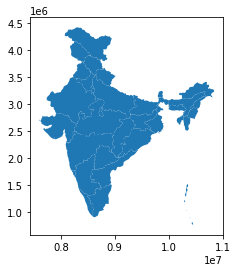

In [13]:
merged_data['data_frame'].plot()

In [0]:
def covid19_plot(covid19_geosource, 
                 input_df=None,
                 input_field=None,
                 plot_title=None,
                 map_overlay=True,
                 enable_toolbar=True):
  #palette = brewer['Oranges']
  #palette = palette[::-1]
  palette = OrRd[9]
  palette = palette[::-1]
  hover = HoverTool(tooltips = [('State','@state'),
                                ('Cases', '@total_cases'),
                                #('Total discharged/migrated', '@discharged'),
                                ('Deaths', '@deaths')])
  color_mapper = LinearColorMapper(palette = palette, 
                                   low = 0, 
                                   high = int(10*(np.ceil(np.max(input_df[input_field].values)/10))))
  format_tick = NumeralTickFormatter(format=str(input_df[input_field].values))
  color_bar = ColorBar(color_mapper=color_mapper, 
                       label_standoff=10, 
                       formatter=format_tick,
                       border_line_color=None, 
                       major_label_text_font_size='16px',
                       location = (0, 0))
  if map_overlay:
    xmin = 8450000
    xmax = 10000000
    ymin = 850000
    ymax = 4550000
  plt = figure(title = plot_title,
               x_range=(xmin, xmax) if map_overlay else None,
               y_range=(ymin, ymax) if map_overlay else None,
               tools='save' if enable_toolbar else '', 
               plot_height = 640, plot_width = 640,
               toolbar_location = 'left' if enable_toolbar else None,
               #lod_factor=int(1e7),
               #lod_threshold=int(2),
               output_backend="webgl")
  if map_overlay:
    wmts = WMTSTileSource(url="http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png")
    plt.add_tile(wmts)
    plt.xaxis.axis_label = 'longitude'
    plt.yaxis.axis_label = 'latitude'
  plt.xgrid.grid_line_color = None
  plt.ygrid.grid_line_color = None
  plt.axis.visible = False
  plt.patches('xs','ys', 
              source = covid19_geosource, 
              fill_color = {'field' : 'deaths', 
                            'transform' : color_mapper},
              line_color = 'purple', 
              line_width = 0.5, 
              fill_alpha = 0.85)
  plt.add_layout(color_bar, 'right')
  plt.add_tools(hover)
  plt.title.text_font_size = '34pt'
  return plt

## Generate COVID19 plot

In [0]:
covid19_geosource=GeoJSONDataSource(geojson=merged_json)
plot_title='COVID19 outbreak in India'
app_title='COVID19 India'

In [0]:
_covid19_plot = covid19_plot(covid19_geosource, 
                             input_df=covid19_data,
                             input_field='deaths',
                             plot_title=plot_title)

In [0]:
curdoc().title=app_title
covid19_layout = column(_covid19_plot)
curdoc().add_root(covid19_layout)

## Display the interactive COVID19 map for India
This generates an interactive COVID19 India outbreak map, within the notebook.
![Bokeh static output](https://github.com/MoadComputer/covid19-visualization/raw/master/examples/COVID19_India_Bokeh_output.png)

The image above is a static screenshot of the Bokeh output. It shows the hover-tool functionality and the save-tool for generating a ```.png``` output. By hovering (devices with a pointer) or single-tapping (touch devices) over the corresponding states, an exapnded summary of COVID19 outbreak in India is displayed.

In [0]:
output_notebook()
show(_covid19_plot)

## [Heroku hosted app](https://covid19india-visualization.herokuapp.com/COVID19_India)
The iframe displays a web version of this notebook, using Heroku.

In [0]:
import IPython
URL = 'https://covid19india-visualization.herokuapp.com/COVID19_India'
FRAME_WIDTH=680
FRAME_HEIGHT=680
iframe = '<iframe src={} width={} height={}></iframe>'.format(URL, 
                                                              FRAME_WIDTH, 
                                                              FRAME_HEIGHT)
IPython.display.HTML(iframe)